**Tabla de contenido**

- [Introducción](#Introducción)
- [Lib](#Lib)
- [Lectura de datos](#Lectura-de-datos)
- [Integridad de los datos](#Integridad-de-los-datos)
- [Feature engineering](#Feature-engineering)
- [Escalado de datos](#Escalado-de-datos)
- [Entrenamiento y prueba](#Entrenamiento-y-prueba)
- [Hyperparameter Optimization](#Hyperparameter-Optimization)
    - [XGBRegressor](#XGBRegressor)
    - [RandomForestRegressor](#RandomForestRegressor)
    - [KNeighborsRegressor](#KNeighborsRegressor)
- [Compentencia entre modelos](#Compentencia-entre-modelos)
- [Mejor modelo](#Mejor-modelo)
- [Cumplimiento de supuestos de la RL](#Cumplimiento-de-supuestos-de-la-RL)
    - [Residual Plot](#Residual-Plot)
    - [Breusch-Pagan test](#Breusch-Pagan-test)
    - [Durbin-Watson test](#Durbin-Watson-test)
    - [Q-Qplot](#Q-Qplot)
    - [Shapiro-Wilk test](#Shapiro-Wilk-test)
    - [VIF](#VIF)
- [Conclusiones](#Conclusiones)

# Introducción

En este cuaderno entrenaremos diversos modelos de regresión lineal para evaluar su precisión en las predicciones, el tiempo requerido para realizar dichas predicciones, el tiempo de entrenamiento y la eficiencia general del proceso.

Posteriormente, seleccionaremos el modelo que presente el mejor desempeño y realizaremos pruebas estadísticas adicionales para garantizar su confiabilidad y robustez.

Los modelos a implementar son los siguientes:

- XGBRegressor
- RandomForestRegressor
- GradientBoostingRegressor
- SVR
- LinearRegression
- Lasso
- Ridge
- ElasticNet
- DecisionTreeRegressor

¡Sin más preámbulos, comencemos!

# Lib

Para garantizar el correcto funcionamiento de este cuaderno, se requieren las siguientes librerías:

- **Python:** Versión 3.12.3
- **Pandas:** Versión 2.2.3
- **Matplotlib:** Versión 3.10.0
- **NumPy:** Versión 1.26.0
- **Seaborn:** Versión 0.13.2
- **Scikit-learn:** Versión 1.5.2
- **Statsmodels:** Versión 0.14.4
- **Optuna:** Versión 4.1.0
- **Scipy:** Versión 1.14.1
- **XGBoost:** Versión 2.1.3

In [63]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Lectura de datos

Los datos fueron leídos desde el archivo **WalmartSalesClean.csv**, que fue exportado desde el cuaderno LDV-APV y utiliza el carácter **","** como delimitador.

**Para leer correctamente este archivo, es necesario proporcionar la ruta donde se encuentra almacenado.**

In [2]:
os.chdir('D:\\6. NEXER\\master\\Solucion TFM\\2. Datos en CSV')
WalmartSales = pd.read_csv('WalmartSalesClean.csv', delimiter=',')
WalmartSales.head()

,Date,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Events
0,2010-02-12,1,164195744,1,38.51,2.548,211.242176,8.106,1
1,2010-02-19,1,161196816,0,39.93,2.514,211.289139,8.106,0
2,2010-02-26,1,140972752,0,46.63,2.561,211.319642,8.106,0
3,2010-03-05,1,155480672,0,46.50,2.625,211.350144,8.106,0
4,2010-03-12,1,143954160,0,57.79,2.667,211.380646,8.106,0


# Integridad de los datos

Este proceso consiste en realizar las siguientes acciones:

- Identificar y manejar registros duplicados (si los hubiera).
- Gestionar datos faltantes (en caso de que existan).
- Verificar y asegurar que los tipos de datos sean los correctos.

¡Procedamos a analizar lo que contienen nuestros datos!

In [3]:
# Función que verifica la integridad de los datos.
def Data_Verification(df):
    rows, cols = df.shape
    missing_values = df.isna().sum().sum()
    duplicates = df.duplicated().sum()
    
    print(f"Information: Hay {rows:,.0f} registros y {cols:,.0f} columnas.")
    print(f"Missing values = {missing_values}, Duplicates = {duplicates}.\n")

Data_Verification(WalmartSales)

Information: Hay 5,763 registros y 9 columnas.
Missing values = 0, Duplicates = 0.



In [4]:
WalmartSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5763 entries, 0 to 5762
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            5763 non-null   object 
 1   Store           5763 non-null   int64  
 2   Weekly_Sales    5763 non-null   int64  
 3   Holiday_Flag    5763 non-null   int64  
 4   Temperature     5763 non-null   float64
 5   Fuel_Price      5763 non-null   float64
 6   CPI             5763 non-null   float64
 7   Unemployment    5763 non-null   float64
 8   Holiday_Events  5763 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 405.3+ KB


**¡Esto es perfecto!** No hay registros faltantes (missing values) ni registros duplicados.

Sin embargo, en el dataframe **"WalmartSales"**, la columna **Date** no está en formato datetime. Vamos a corregir esto.

In [5]:
WalmartSales['Date'] = pd.to_datetime(WalmartSales['Date'],format = '%Y-%m-%d')

# Feature engineering

Vamos a descomponer la fecha en columnas predictoras. Esto involucra crear diferentes columnas, como son día, mes, año, día semana, trimestres y semanas del año.

In [6]:
WalmartSales['Day'] = WalmartSales['Date'].dt.day
WalmartSales['Weekday'] = WalmartSales['Date'].dt.weekday
WalmartSales['Month'] = WalmartSales['Date'].dt.month
WalmartSales['Year'] = WalmartSales['Date'].dt.year
WalmartSales['week'] = WalmartSales['Date'].dt.isocalendar().week
WalmartSales['quarter'] = WalmartSales['Date'].dt.quarter 
WalmartSales = WalmartSales.drop('Date', axis=1)
WalmartSales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Events,Day,Weekday,Month,Year,week,quarter
0,1,164195744,1,38.51,2.548,211.242176,8.106,1,12,4,2,2010,6,1
1,1,161196816,0,39.93,2.514,211.289139,8.106,0,19,4,2,2010,7,1
2,1,140972752,0,46.63,2.561,211.319642,8.106,0,26,4,2,2010,8,1
3,1,155480672,0,46.50,2.625,211.350144,8.106,0,5,4,3,2010,9,1
4,1,143954160,0,57.79,2.667,211.380646,8.106,0,12,4,3,2010,10,1


# Escalado de datos

El escalador de datos que vamos a usar será **RobustScaler()**, pues suele elegirse si los datos tienen valores atípicos o no se distribuyen normalmente. Hace que las variables continuas sean robustas a los valores atípicos, pero no las lleva necesariamente a la misma escala que las características codificadas con un solo disparo.

In [7]:
def normalizar_datos (target,df):
    X = df.drop(columns=[target],axis=1)
    y = df[target]
    escalador = preprocessing.RobustScaler()
    X_nor = pd.DataFrame(escalador.fit_transform(X),
                         columns = X.columns,
                         index=X.index)
    dfnor = pd.concat([y,X_nor],axis=1)
    return dfnor

In [8]:
df1 = WalmartSales.copy()

In [9]:
df1nor = normalizar_datos (target='Weekly_Sales',
                          df = df1)

# Entrenamiento y prueba

Con los dos dataframes escalados, separaremos un 80% de datos para entrenamiento y un 20% para test, y entrenaremos los modelos en su estado predeterminado.

In [10]:
independientes = df1nor.drop(columns=['Weekly_Sales'],axis=1) 
objetivo = df1nor['Weekly_Sales']

X_train, X_test, Y_train, Y_test = train_test_split(independientes,
                                                    objetivo,
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
def model(Y_test, Y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)
    # Calcular métricas
    mse = mean_squared_error(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred) * 100
    # Imprimir resultados
    print('-----------------')
    print(model.__name__)
    print('-----------------')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R2 : {round(r2, 2)} %')
    # Devolver el modelo entrenado
    return model_instance
    
x = [model(Y_test, Y_train, X_test, X_train, i) for i in [
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet,
    RandomForestRegressor,
    DecisionTreeRegressor,
    KNeighborsRegressor,
    GradientBoostingRegressor,
    XGBRegressor,
    SVR
    ]]

-----------------
LinearRegression
-----------------
MSE: 2831310798748848.5
MAE: 43746750.17724809
R2 : 15.19 %
-----------------
Lasso
-----------------
MSE: 2829311221517238.5
MAE: 43732088.34709036
R2 : 15.25 %
-----------------
Ridge
-----------------
MSE: 2829399417076720.5
MAE: 43732811.40950648
R2 : 15.25 %
-----------------
ElasticNet
-----------------
MSE: 3018814964079387.5
MAE: 45702475.71502793
R2 : 9.57 %


C:\Users\anboo\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.166e+18, tolerance: 1.455e+15
  model = cd_fast.enet_coordinate_descent(


-----------------
RandomForestRegressor
-----------------
MSE: 100246849805178.56
MAE: 5403749.7719514305
R2 : 97.0 %
-----------------
DecisionTreeRegressor
-----------------
MSE: 148706645843901.0
MAE: 6720447.784908934
R2 : 95.55 %
-----------------
KNeighborsRegressor
-----------------
MSE: 2082500040850201.5
MAE: 35213431.204856895
R2 : 37.62 %
-----------------
GradientBoostingRegressor
-----------------
MSE: 351497109811468.44
MAE: 13806501.477737097
R2 : 89.47 %
-----------------
XGBRegressor
-----------------
MSE: 78853724689358.83
MAE: 5065163.019947962
R2 : 97.64 %
-----------------
SVR
-----------------
MSE: 3438462285323254.0
MAE: 47437409.81506029
R2 : -3.0 %


Podemos observar que los modelos con mejor coeficiente de determinación fueron:

- **XGBRegressor:** Con un R2 de 97.64 %.
- **RandomForestRegressor:** Con un R2 de 96.91 %.
- **DecisionTreeRegressor:** Con un R2 de 95.36 %.
- **GradientBoostingRegressor**: Con un R2 de 89.47 %.

Veamos cuáles son los parámetros por defecto de estos mejores modelos.

In [12]:
# Inspeccionar parámetros de los mejores modelos
model_names = ["XGBRegressor", "RandomForestRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor"]
for model_instance in x:
    if model_instance.__class__.__name__ in model_names:
        print(f"\nParámetros de {model_instance.__class__.__name__}:")
        print(model_instance.get_params())


Parámetros de RandomForestRegressor:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Parámetros de DecisionTreeRegressor:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

Parámetros de GradientBoostingRegressor:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_imp

# Hyperparameter Optimization

Durante el entrenamiento de los modelos con sus configuraciones por defecto, observamos que varios lograron explicar más del 80% de la variabilidad de los datos de ventas semanales. Sin embargo, exploraremos la posibilidad de optimizar los parámetros de cada modelo y someterlos a una comparación para determinar cuál ofrece el mejor rendimiento y predicciones.

La optimización de hiperparámetros se realizará utilizando **Optuna**, una herramienta diseñada para minimizar o maximizar una función objetivo. En este caso, la función objetivo a maximizar será el coeficiente de determinación R2. Para ello, aplicaremos validación cruzada y tomaremos una muestra del DataFrame, lo que nos permitirá validar el modelo que ofrezca el mejor rendimiento.

A continuación, definimos la función **evaluar_modelo**; esta se encargará de evaluar los modelos utilizando validación cruzada.

In [13]:
def evaluar_modelo(estimador, independientes, objetivo):
    resultados_estimador = cross_validate(estimador, independientes, objetivo,
                     scoring="r2", n_jobs=-1, cv=30)
    return resultados_estimador

## XGBRegressor

In [14]:
def optimizar_xgb(trial):
    param_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),  # Número de árboles
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),  # Tasa de aprendizaje
        'max_depth': trial.suggest_int('max_depth', 2, 12),  # Profundidad máxima de los árboles
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),  # Peso mínimo de una hoja
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.1),  # Proporción de muestras por árbol
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.1),  # Proporción de características por árbol
        'gamma': trial.suggest_float('gamma', 0.0, 1.0, step=0.1),  # Reducción de la pérdida al dividir un nodo
    }
    xgb = XGBRegressor(**param_xgb)
    resultados_xgb = cross_validate(xgb,independientes , objetivo, scoring="r2", n_jobs=-1, cv=10)
    return np.mean(resultados_xgb["test_score"])

Saquemos la muestra y entremos el modelo.

In [15]:
datanor, muestra = train_test_split(df1nor, test_size=0.2, random_state=42)
datanor = datanor.reset_index(drop=True)
muestra =muestra.reset_index(drop=True)

In [16]:
independientes =datanor.drop(columns=['Weekly_Sales'],axis=1)
objetivo = datanor['Weekly_Sales']
estudioXGBRegressor= optuna.create_study(direction="maximize")
n_trials = 50  
estudioXGBRegressor.optimize(optimizar_xgb, n_trials=n_trials)

[I 2025-01-15 13:18:28,903] A new study created in memory with name: no-name-425ce638-d9a1-4de2-959b-ec81eed282f8
[I 2025-01-15 13:18:33,788] Trial 0 finished with value: 0.737246835231781 and parameters: {'n_estimators': 87, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.5, 'colsample_bytree': 0.4, 'gamma': 0.8}. Best is trial 0 with value: 0.737246835231781.
[I 2025-01-15 13:18:36,088] Trial 1 finished with value: 0.7861085951328277 and parameters: {'n_estimators': 86, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'gamma': 0.5}. Best is trial 1 with value: 0.7861085951328277.
[I 2025-01-15 13:18:36,284] Trial 2 finished with value: 0.7333097279071807 and parameters: {'n_estimators': 96, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 19, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 1.0}. Best is trial 1 with value: 0.7861085951328277.
[I 2025-01-15 13:18:36,540]

In [17]:
print(estudioXGBRegressor.best_params)

{'n_estimators': 81, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6, 'gamma': 0.8}


**Podemos ver que el modelo XGBRegressor con los diferentes parámetros establecidos alcanzó un 0.9736 en R2.**

## RandomForestRegressor

In [20]:
def optimizar_Forestre(trial):
    param_grid_rf = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 100),  # Número de árboles
        'max_depth': trial.suggest_int('max_depth', 2, 12),  # Profundidad de los árboles
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 1.0]),  # Características a usar para dividir un nodo
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),  # Mínimas muestras para dividir un nodo
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),  # Mínimas muestras en una hoja
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # Si usar muestreo con reemplazo
    }
    
    Forestre = RandomForestRegressor(**param_grid_rf)
    resultados_Forestre = cross_validate(Forestre, independientes, objetivo, scoring="r2", n_jobs=-1, cv=10)
    return np.mean(resultados_Forestre["test_score"])

In [21]:
estudioRandomForestRegressor= optuna.create_study(direction="maximize")
n_trials = 50  
estudioRandomForestRegressor.optimize(optimizar_Forestre, n_trials=n_trials)

[I 2025-01-15 13:32:24,757] A new study created in memory with name: no-name-4f0fe070-f852-49c4-a798-bfd1ca219b45
[I 2025-01-15 13:32:25,838] Trial 0 finished with value: 0.94883809720485 and parameters: {'n_estimators': 34, 'max_depth': 9, 'max_features': 1.0, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.94883809720485.
[I 2025-01-15 13:32:27,090] Trial 1 finished with value: 0.9556748306941583 and parameters: {'n_estimators': 50, 'max_depth': 10, 'max_features': 0.8, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.9556748306941583.
[I 2025-01-15 13:32:27,283] Trial 2 finished with value: 0.6074602638910688 and parameters: {'n_estimators': 18, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.9556748306941583.
[I 2025-01-15 13:32:28,704] Trial 3 finished with value: 0.9618531497593266 and parameters:

In [22]:
print(estudioRandomForestRegressor.best_params)

{'n_estimators': 66, 'max_depth': 12, 'max_features': 0.8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}


## GradientBoostingRegressor

In [23]:
def optimizar_GradientBoostingRegressor(trial):
    param_GraBR = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 100),  # Número de árboles
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),  # Tasa de aprendizaje
        'max_depth': trial.suggest_int('max_depth', 2, 12),  # Profundidad máxima de cada árbol
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),  # Mínimas muestras para dividir un nodo
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),  # Mínimas muestras en una hoja
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fracción de muestras para cada árbol
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),  # Criterio para la división
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),  # Si reutiliza los resultados previos
        'tol': trial.suggest_float('tol', 0.0001, 0.01),  # Tolerancia para la parada anticipada
    }
    
    gradientBR = GradientBoostingRegressor(**param_GraBR)
    resultados_gradientBR = cross_validate(gradientBR, independientes, objetivo, scoring="r2", n_jobs=-1, cv=5)
    return np.mean(resultados_gradientBR["test_score"]) 

In [24]:
estudioGradientBoostingRegressor= optuna.create_study(direction="maximize")
n_trials = 50  
estudioGradientBoostingRegressor.optimize(optimizar_GradientBoostingRegressor, n_trials=n_trials)

[I 2025-01-15 13:55:50,940] A new study created in memory with name: no-name-8d4457ef-3119-425f-834f-c38859cfb123
[I 2025-01-15 13:55:58,208] Trial 0 finished with value: 0.9639812444952669 and parameters: {'n_estimators': 91, 'learning_rate': 0.1, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.9892015817110913, 'criterion': 'friedman_mse', 'warm_start': True, 'tol': 0.004422066115895258}. Best is trial 0 with value: 0.9639812444952669.
[I 2025-01-15 13:56:02,055] Trial 1 finished with value: 0.97074758316424 and parameters: {'n_estimators': 39, 'learning_rate': 0.1, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.5797734535151904, 'criterion': 'friedman_mse', 'warm_start': False, 'tol': 0.0007723483293349771}. Best is trial 1 with value: 0.97074758316424.
[I 2025-01-15 13:56:05,351] Trial 2 finished with value: 0.8388557339007608 and parameters: {'n_estimators': 21, 'learning_rate': 0.05, 'max_depth': 9, 'min_samples_split'

In [25]:
print(estudioGradientBoostingRegressor.best_params)

{'n_estimators': 93, 'learning_rate': 0.1, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.692131006950942, 'criterion': 'squared_error', 'warm_start': False, 'tol': 0.004043284891718401}


## KNeighborsRegressor

In [33]:
def optimizar_KNeighborsRegressor(trial):
    param_KNReg = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),  # Número de vecinos a considerar
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  # Método de ponderación de los vecinos
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),  # Algoritmo para encontrar los vecinos más cercanos
        'leaf_size': trial.suggest_int('leaf_size', 20, 60),  # Tamaño de la hoja para ball_tree/kd_tree
        'p': trial.suggest_int('p', 1, 2),  # Parámetro de la métrica de distancia (1 para Manhattan, 2 para Euclidiana)
        'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']),  # Métrica para el cálculo de distancias
        'n_jobs': -1,  # Usa todos los núcleos disponibles para el cálculo en paralelo
    }
    
    KNRegressor = KNeighborsRegressor(**param_KNReg)
    resultados_KNRegressor = cross_validate(KNRegressor, independientes, objetivo, scoring="r2", n_jobs=-1, cv=5)
    return np.mean(resultados_KNRegressor["test_score"])

In [34]:
estudioKNRegressor = optuna.create_study(direction="maximize")
n_trials = 50  
estudioKNRegressor.optimize(optimizar_KNeighborsRegressor, n_trials=n_trials)

[I 2025-01-15 14:07:12,461] A new study created in memory with name: no-name-1959ddc7-e3ae-4320-bc53-d24cd0a5c59e
[I 2025-01-15 14:07:12,532] Trial 0 finished with value: 0.28254862921810026 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 43, 'p': 2, 'metric': 'minkowski'}. Best is trial 0 with value: 0.28254862921810026.
[I 2025-01-15 14:07:12,648] Trial 1 finished with value: 0.3057078516287775 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 40, 'p': 1, 'metric': 'euclidean'}. Best is trial 1 with value: 0.3057078516287775.
[I 2025-01-15 14:07:12,773] Trial 2 finished with value: 0.4058646770315696 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 59, 'p': 2, 'metric': 'manhattan'}. Best is trial 2 with value: 0.4058646770315696.
[I 2025-01-15 14:07:12,889] Trial 3 finished with value: 0.29438353097844383 and parameters: {'n_neighbors': 15, 'weights': 'un

In [35]:
print(estudioKNRegressor.best_params)

{'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 53, 'p': 1, 'metric': 'manhattan'}


# Compentencia entre modelos

Con los parámetros óptimos encontrados para cada modelo, evaluaremos su desempeño. Para ello, crearemos una función que calcule el R2 ajustado, el tiempo de entrenamiento y el tiempo de predicción de cada modelo.

In [36]:
def ver_resultados(resultados):
    resultados_df = pd.DataFrame(resultados).T
    # Iterar sobre cada columna del DataFrame
    for col in resultados_df:
        resultados_df[col] = resultados_df[col].apply(np.mean)
        resultados_df[col + "_idx"] = resultados_df[col] / resultados_df[col].max()
    return resultados_df

Obtenemos los resultados de los modelos con sus parámetros óptimos encontrados, utilizando 30 particiones en validación cruzada para obtener estimaciones más estables y confiables del rendimiento.

In [37]:
xgb = XGBRegressor(**estudioXGBRegressor.best_params)
forest = RandomForestRegressor(**estudioRandomForestRegressor.best_params)
gradient = GradientBoostingRegressor(**estudioGradientBoostingRegressor.best_params)
KNreg = KNeighborsRegressor(**estudioKNRegressor.best_params)
resultados = {}

resultados["XGRegressor"] = evaluar_modelo(xgb,
                                   independientes,
                                   objetivo)
resultados["RandomForestRegressor"] = evaluar_modelo(forest,
                                   independientes,
                                   objetivo)
resultados["GradientBoostingRegressor"] = evaluar_modelo(gradient,
                                   independientes,
                                   objetivo)
resultados["KNreg"] = evaluar_modelo(KNreg,
                                   independientes,
                                   objetivo)

Veamos los resultados.

In [38]:
resultados_df= ver_resultados(resultados)
resultados_df = resultados_df.sort_values(by=['test_score', 'fit_time'], ascending=[False, True])
resultados_df.head()

,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
GradientBoostingRegressor,3.628156,0.005819,0.979082,1.000000,0.336756,1.000000
XGRegressor,0.494484,0.011986,0.973896,0.136291,0.693717,0.994704
RandomForestRegressor,2.934087,0.013201,0.966602,0.808699,0.763991,0.987253
KNreg,0.020909,0.017279,0.440367,0.005763,1.000000,0.449775


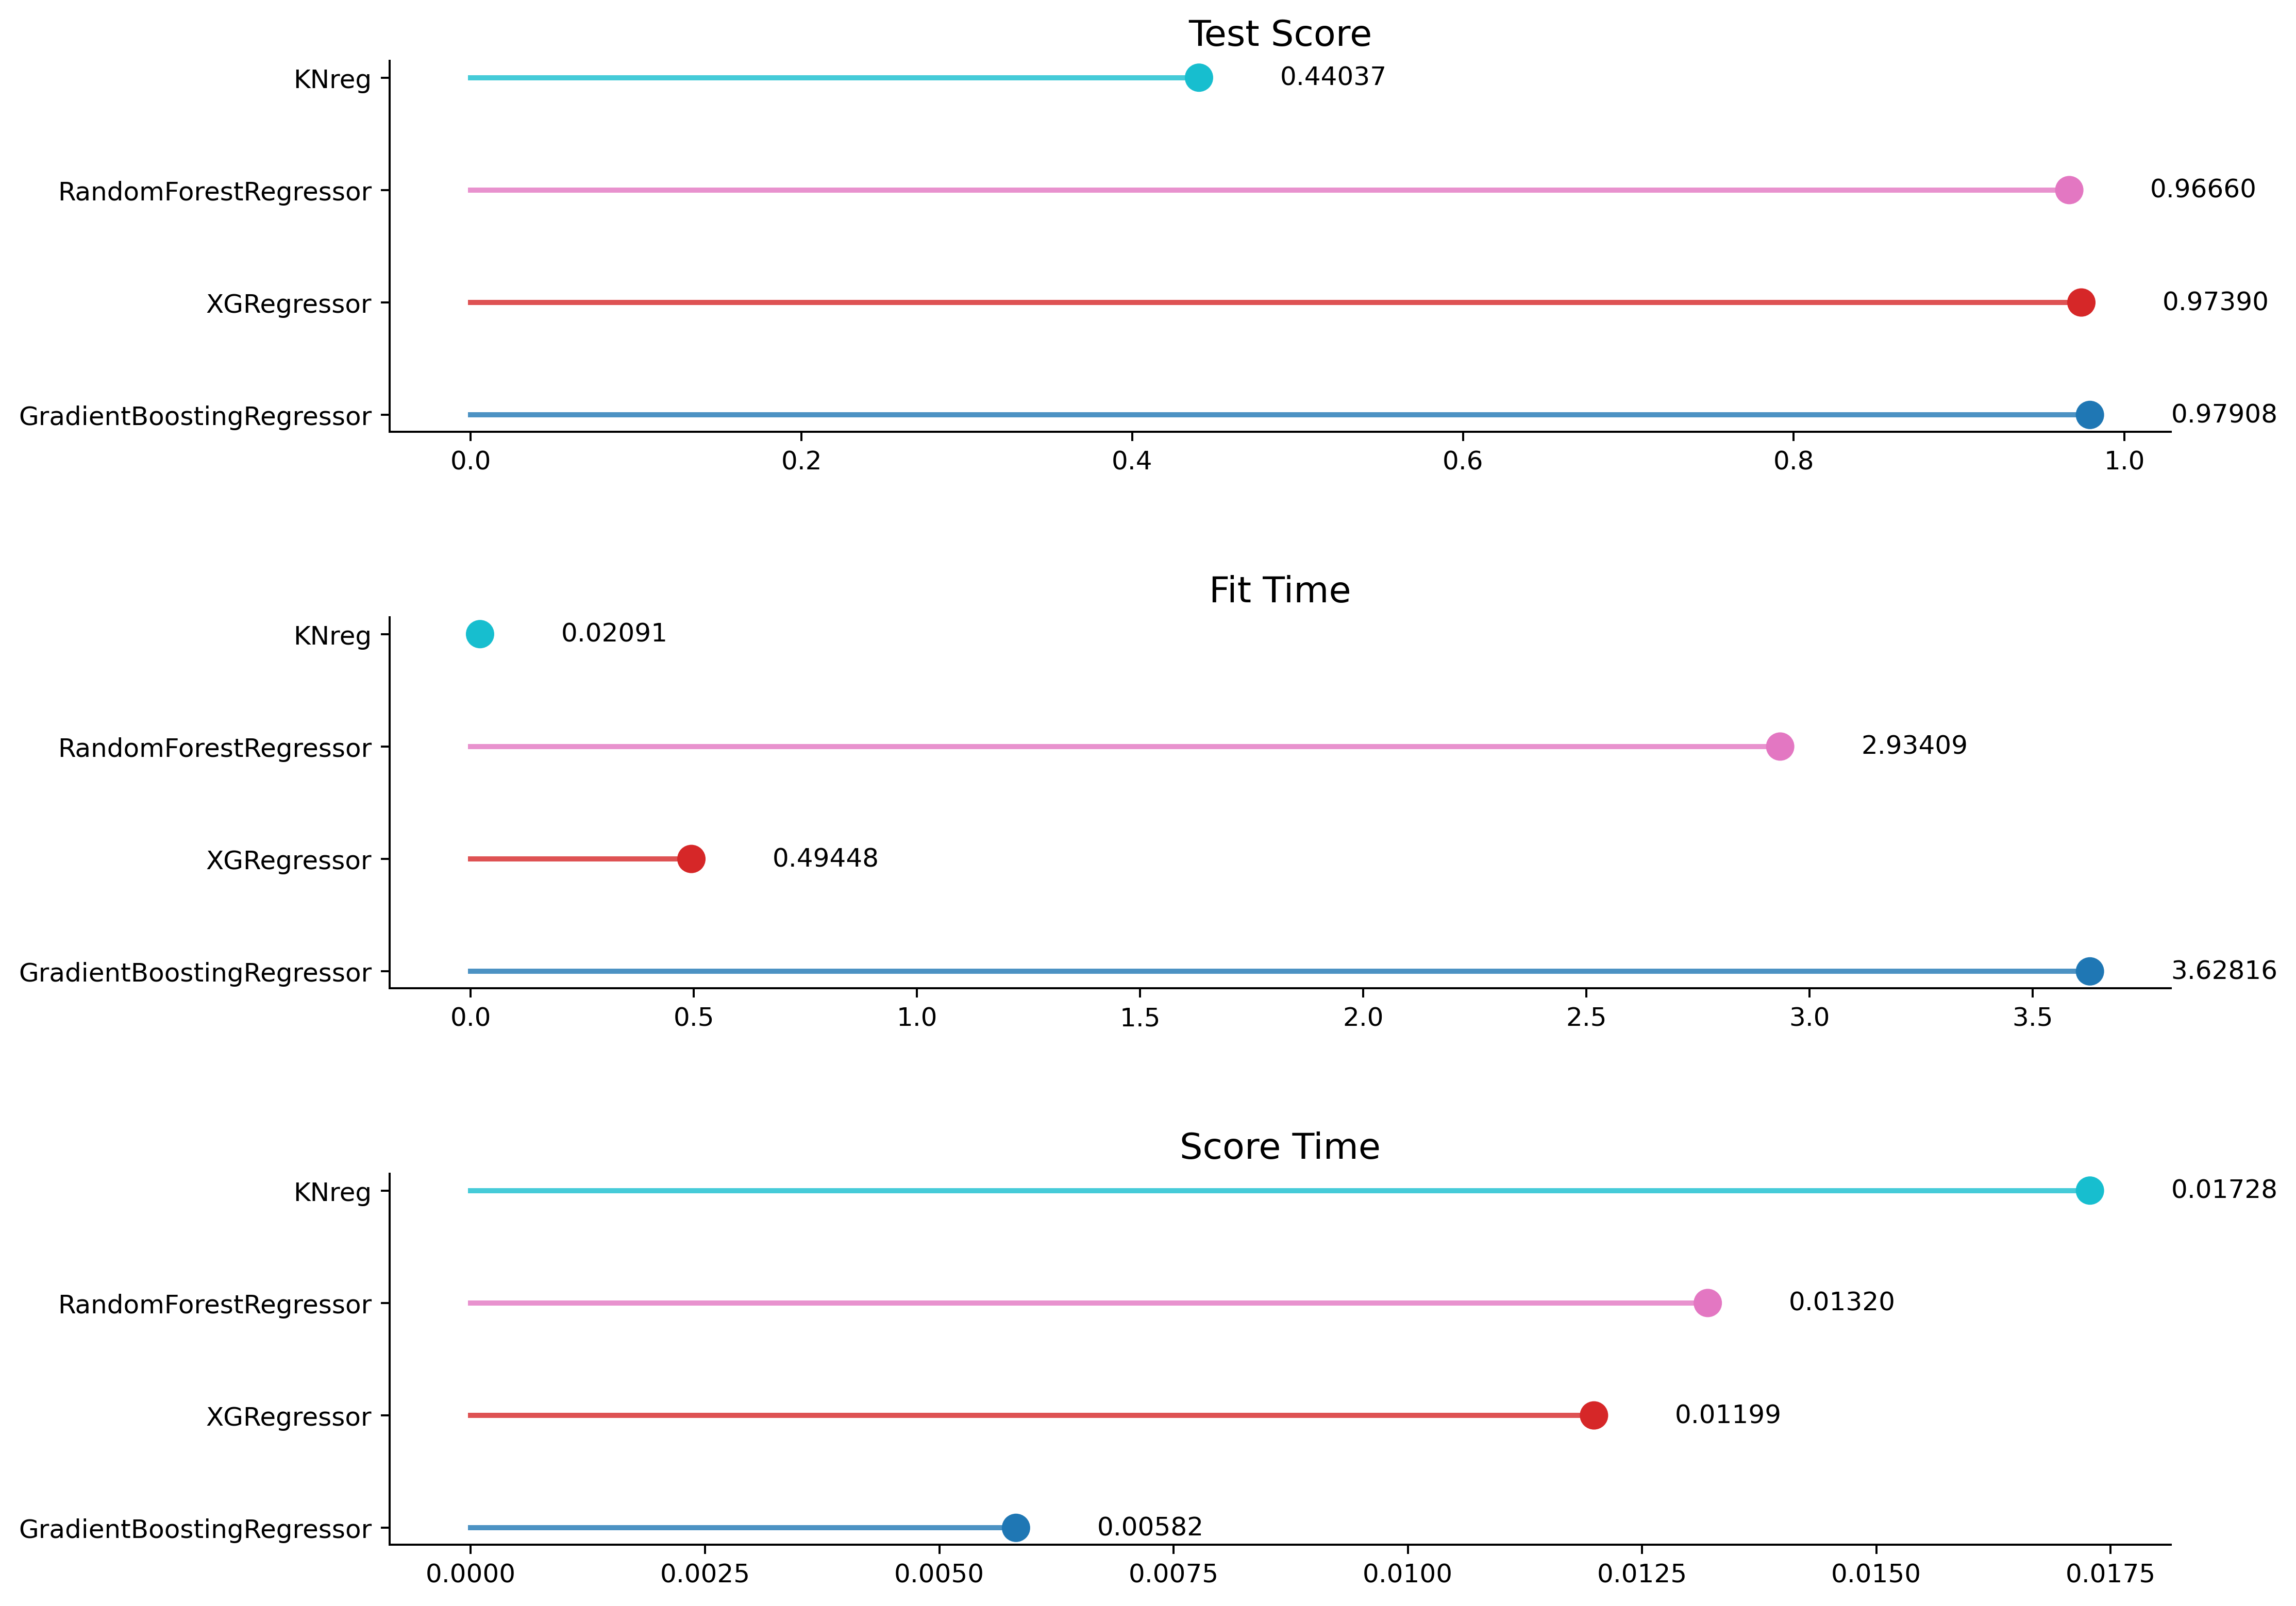

In [39]:
fig = plt.figure(figsize=(12, 10),dpi=360)

# Métricas a graficar
metrics = ["test_score", "fit_time", "score_time"]
titles = ["Test Score", "Fit Time", "Score Time"]


for i, (metric, title) in enumerate(zip(metrics, titles)):
    # Crear subplot dinámico
    ax = fig.add_axes([0.1, 0.7 - i * 0.3, 0.8, 0.2]) 

    # Extraer datos
    x = resultados_df.index  # Los modelos (índices del DataFrame)
    y = resultados_df[metric]

    # Generar colores automáticamente
    colores = plt.cm.tab10(np.linspace(0, 1, len(x)))

    # Dibujar las líneas verticales
    for xi, yi, color in zip(x, y, colores):
        ax.plot([0, yi], [xi, xi], color=color, lw=2, alpha=0.8)

    # Dibujar los puntos
    ax.scatter(y, x, color=colores, s=100, zorder=2)

    # Añadir los valores como texto
    max_y = max(abs(y)) 
    for yi, xi in zip(y, x):
        texto_x = yi + (max_y * 0.05 if yi >= 0 else -max_y * 0.05)
        ax.text(texto_x, xi, f'{yi:.5f}', va='center', ha='left')

    # Configuración del subplot
    ax.set_title(title, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

Podemos observar lo siguiente:

- **GradientBoostingRegressor:** Es el modelo con la mejor puntuación en el coeficiente de determinación (R2=0.979). Aunque requiere más tiempo para entrenarse, compensa siendo el más rápido al realizar predicciones.

- **XGRegressor:** Se posiciona como el segundo mejor modelo en términos de R22 (R2=0.973). Además, es eficiente en el entrenamiento y la predicción, ocupando el segundo lugar en ambas métricas de tiempo.

- **RandomForestRegressor:** Obtiene la tercera mejor puntuación en el coeficiente de determinación (R2=0.96). Sin embargo, es el segundo modelo más lento en el entrenamiento y el tercero más lento al realizar predicciones.

- **KNeighborsRegressor:** Es el modelo de menor desempeño.

A pesar de que la diferencia en R2 entre GradientBoostingRegressor y XGRegressor es mínima, hemos seleccionado a XGRegressor como el modelo más adecuado. Esta decisión se fundamenta en que ofrece un balance óptimo entre precisión (R2 de 0.97), tiempo de entrenamiento y tiempo de predicción.

# Mejor modelo

Veamos qué tan bien son las predicciones con el mejor modelo (XGRegressor).

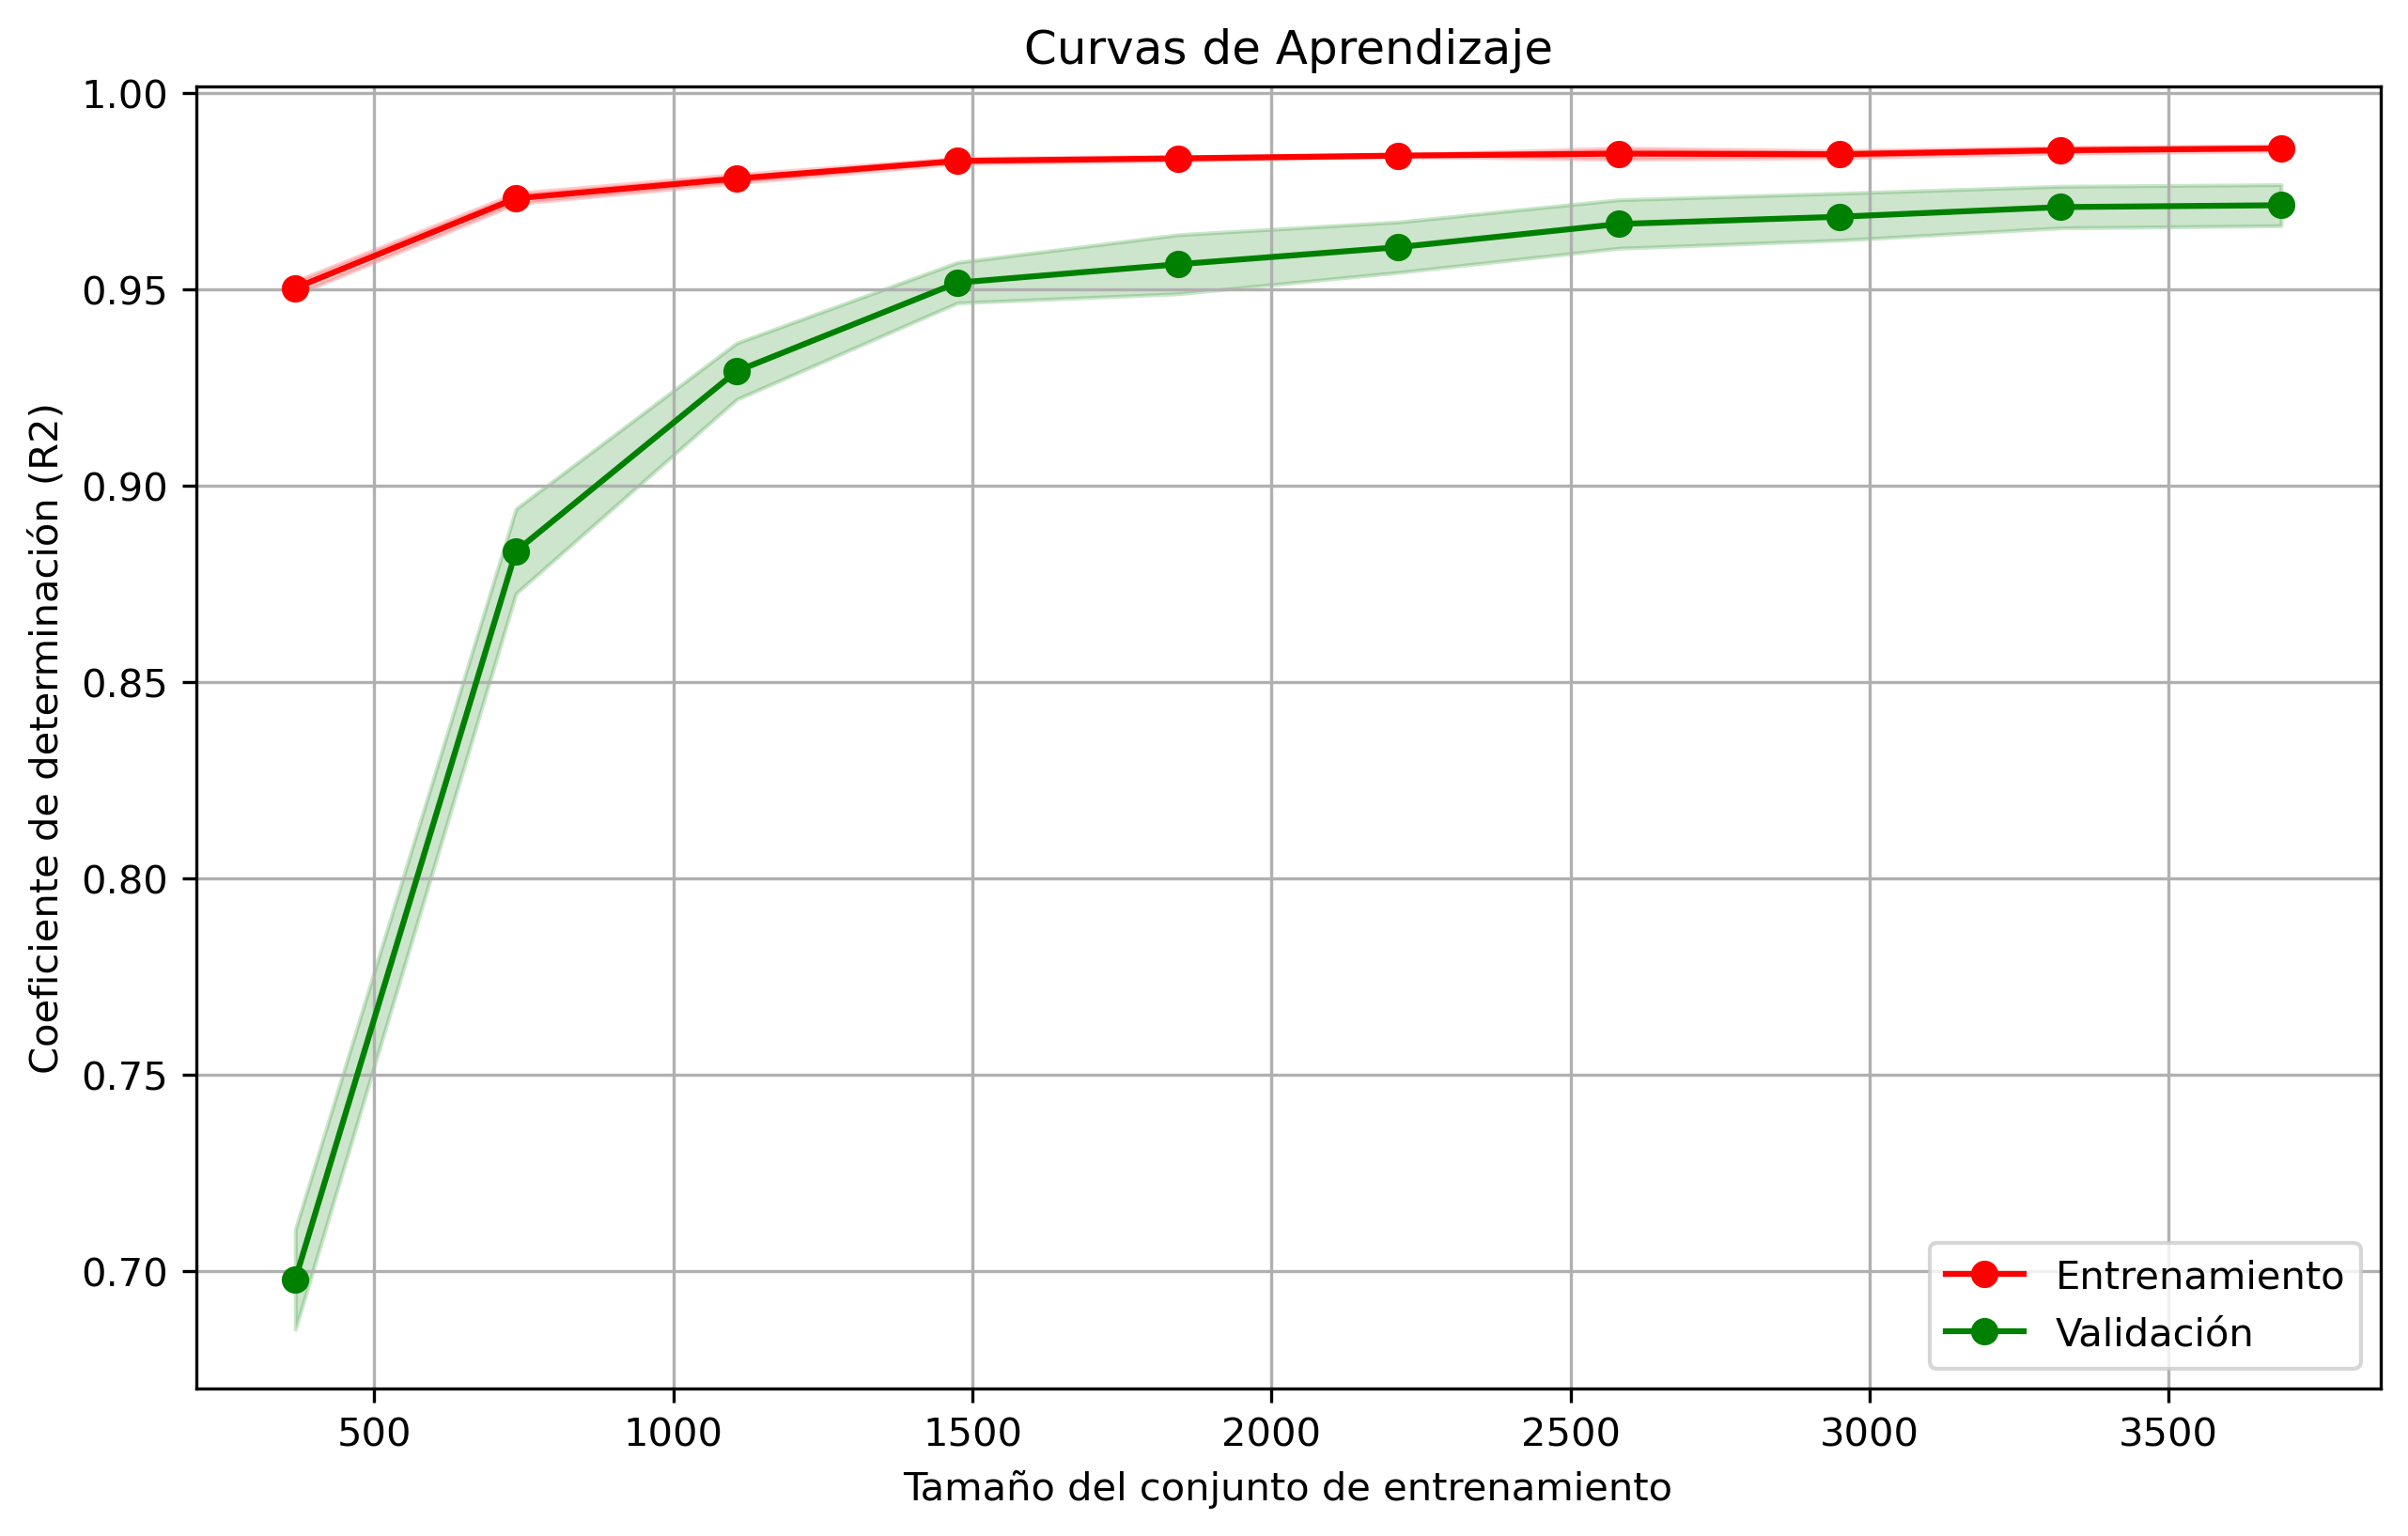

In [50]:
mejorModelo = XGBRegressor(**estudioXGBRegressor.best_params)

# Generar curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    mejorModelo,            
    independientes,         
    objetivo,               
    cv=5,                   
    scoring='r2',           
    train_sizes=np.linspace(0.1, 1.0, 10),  # Tamaños de entrenamiento
    n_jobs=-1               
)

# Promedio y desviación estándar de los puntajes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Gráfica de las curvas de aprendizaje
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.2)

# Etiquetas y leyenda
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Coeficiente de determinación (R2)")
plt.legend(loc="best")
plt.grid()
plt.show()

El modelo no muestra signos de sobreajuste, ya que las curvas de aprendizaje son razonablemente cercanas y la curva de validación no se estabiliza en un valor significativamente inferior al de entrenamiento. A continuación, evaluaremos las predicciones utilizando una muestra que el modelo no ha visto previamente.

In [49]:
mejorModelo =XGBRegressor(**estudioXGBRegressor.best_params)
mejorModelo.fit(independientes, objetivo)
prediciones = mejorModelo.predict(muestra.drop(columns=['Weekly_Sales'],axis=1))
prediciones = mejorModelo.predict(muestra.drop(columns=['Weekly_Sales'],axis=1))
MAE = metrics.mean_absolute_error(muestra['Weekly_Sales'], prediciones)
MSE = metrics.mean_squared_error(muestra['Weekly_Sales'], prediciones)
RMSE = np.sqrt(MSE)
error_Observacion= np.absolute(muestra['Weekly_Sales'] - prediciones)
coeficiente_determinacion = metrics.r2_score(muestra['Weekly_Sales'], prediciones)
n = len(muestra['Weekly_Sales'])
k = len(estudioXGBRegressor.best_params) 
# Calculando R2 ajustado
PorcentajeError = (RMSE*100)/(muestra['Weekly_Sales'].mean())
R2_ajustado = 1 - ((1 - coeficiente_determinacion) * (n - 1)) / (n - k - 1)
print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"Coeficiente de determinación (R2): {coeficiente_determinacion}")
print(f"R2 ajustado: {R2_ajustado}")
print(f"PorcentajeError: {PorcentajeError}")

MAE: 5940870.31916739
MSE: 99343347007351.92
RMSE: 9967113.273528697
Coeficiente de determinación (R2): 0.9702425599098206
R2 ajustado: 0.9700606366952954
PorcentajeError: 9.393602630992284


- El modelo tiene un buen R2 (0.97), lo que sugiere que es capaz de explicar una proporción significativa de la variabilidad de la variable objetivo.

- La métrica RMSE = 9967113.27 indica que el modelo presenta un error aproximado del 9.43%, lo cual es inferior al 10% en relación con el promedio de las ventas. Este bajo porcentaje sugiere que el modelo está realizando predicciones relativamente precisas. Un error menor al 10% se considera generalmente aceptable, lo que refuerza la confiabilidad de las predicciones del modelo.

- La diferencia entre R2 y R2 ajustado es pequeña, lo que sugiere que el modelo no está sobreajustado a las variables, y su rendimiento general es estable.

# Cumplimiento de supuestos de la RL

Vamos a comprobar si el modelo cumple con los supuestos de la regresión lineal; esto incluye las siguientes pruebas:

- **Residual Plot**
- **Breusch-Pagan test**
- **Durbin-Watson test**
- **Q-Qplot**
- **Shapiro-Wilk test**
- **Factor de Inflación de la Varianza VIF**

## Residual Plot

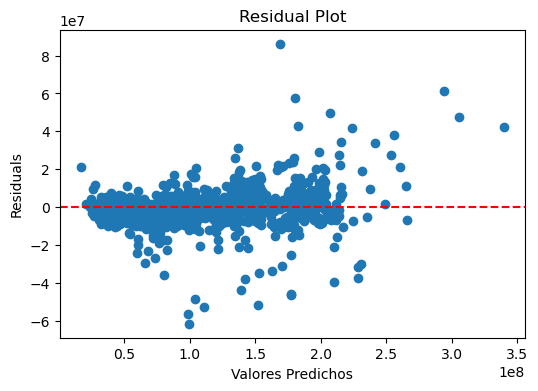

In [51]:
residuals = muestra['Weekly_Sales'] - prediciones
# graficando residuales
plt.figure(figsize=(6, 4))
plt.scatter(prediciones, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Se puede observar que:

- Los residuos parecen estar centrados alrededor de 0, lo cual es una buena señal porque indica que el modelo no tiene un sesgo sistemático.
- Sin embargo, hay puntos alejados (outliers) tanto en valores positivos como negativos, lo que podría indicar algunas observaciones atípicas o problemas con el modelo para ciertos rangos de valores.
- Existe cierta dispersión en los residuos que parece constante para la mayoría de los valores predichos, lo cual es un indicador positivo porque implica homocedasticidad.
- No se observa un patrón claro o estructura en los residuos (como curvas o tendencias), lo cual sugiere que el modelo captura bien las relaciones lineales entre las variables.

## Breusch-Pagan test

Verifiquemos si existe homocedasticidad en los residuos.
    
- **Hipótesis nula (H0):** Los residuos son homocedásticos, es decir, tienen varianza constante.

- **Hipótesis alternativa (H1):** Los residuos son heterocedásticos, es decir, su varianza cambia en función de las variables explicativas.

**Si p-value > 0.05, no se puede rechazar la hipótesis nula.**

**Si p-value < 0.05, se puede rechazar la hipótesis nula.**

In [56]:
# Añade la constante al conjunto de variables predictoras
X_with_constant = sm.add_constant(muestra.drop(columns=['Weekly_Sales'], axis=1))
bp_test = sms.het_breuschpagan(residuals, X_with_constant)
print('Estadístico de Breusch-Pagan:', bp_test[0])
print('p-valor:', bp_test[1])

Estadístico de Breusch-Pagan: 109.86082286198553
p-valor: 1.9891144387299234e-17


Se rechaza la hipótesis nula y se afirma que existe heterocedasticidad en los residuos.

El resultado de la prueba de Breusch-Pagan sugiere que hay evidencia fuerte de heterocedasticidad en el modelo. Esto significa que la varianza de los residuos no es constante, lo que puede afectar la precisión de los estimadores y las inferencias estadísticas.

## Durbin-Watson test

Se usa para detectar autocorrelación.

Interpretación del valor:

- Valor cercano a 2: Indica poca o ninguna autocorrelación.
- Valor cercano a 0: Indica autocorrelación positiva (los errores tienden a seguir patrones).
- Valor cercano a 4: Indica autocorrelación negativa.

In [58]:
dw_test = durbin_watson(residuals)
print(f'Durbin-Watson test statistic: {dw_test}')

Durbin-Watson test statistic: 1.9890790158193772


Podemos ver que el valor es muy cercano a 2; esto indica que el modelo no presenta problemas de autocorrelación en los residuos. Esto indica que el modelo cumple con **la independencia de los errores**. **¡Esto es perfecto!**

## Q-Qplot

Veamos si los residuos siguen una distribución normal.

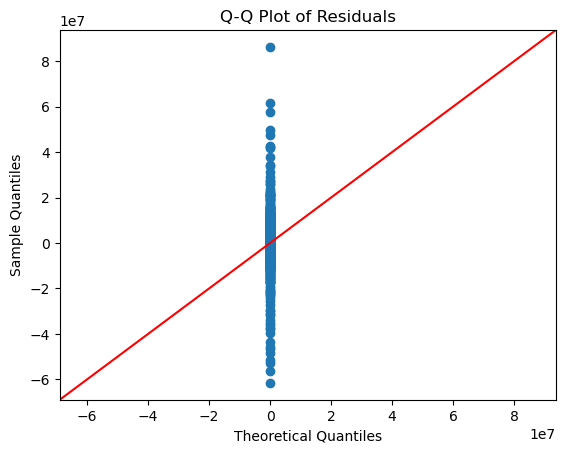

In [59]:
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

El gráfico indica que los residuales no siguen una distribución normal, lo cual es un supuesto importante en muchos modelos lineales y en la evaluación de la significancia estadística.

## Shapiro-Wilk test

Comprobemos lo visto en el gráfico Q-Qplot.

- Hipótesis nula (H0): Los datos siguen una distribución normal.
- Hipótesis alternativa (H1): Los datos no siguen una distribución normal.

p-valor > 0.05, no se rechaza la hipótesis nula.

In [61]:
shapiro_test = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value:', shapiro_test[1])

Shapiro-Wilk test p-value: 2.4861551585518767e-35


Se rechaza la hipótesis nula, lo que afirma que los residuos no siguen una distribución normal.

## VIF

Valores altos de VIF (generalmente mayores a 10) indican que una variable está altamente correlacionada con las demás, lo que puede causar inestabilidad en las estimaciones de los coeficientes del modelo.

In [65]:
vif_data = pd.DataFrame()
X = muestra.drop(columns=['Weekly_Sales'], axis=1) 
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filtrar e imprimir las variables con VIF > 5
high_vif = vif_data[vif_data["VIF"] > 5]

if not high_vif.empty:
    print("Variables con VIF mayor a 5:")
    print(high_vif)
    # Eliminar variables con VIF muy alto
    X = X.drop(columns=high_vif["feature"])
else:
    print("No hay variables con VIF mayor a 5.")

Variables con VIF mayor a 5:
           feature         VIF
1     Holiday_Flag         inf
6   Holiday_Events         inf
9            Month  193.641018
11            week  114.902929
12         quarter   19.021480


C:\Users\anboo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\anboo\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Hay variables altamente correlacionadas, lo que sugiere una multicolinealidad fuerte. Lo que hace que no se cumpla el supuesto de **no multicolinealidad perfecta**. Esto podría afectar las estimaciones de los coeficientes de regresión y hacer que el modelo sea menos fiable.

# Conclusiones

Conclusiones del análisis del modelo:
1) **Desempeño del modelo:**
El modelo XGRegressor fue el mejor en las pruebas realizadas, logrando un coeficiente de determinación ajustado (R2) del 0.97 en las pruebas de validación. Este valor indica que el modelo captura una proporción significativa de la variabilidad de los datos, aunque hay margen para mejorar el ajuste.

2) **Linealidad:** Cumplido parcialmente.
En el gráfico de residuales, los puntos están distribuidos alrededor de la línea roja, lo que sugiere que el modelo captura bien la relación lineal general entre las variables. Sin embargo, los valores atípicos y la heterocedasticidad observada podrían afectar este supuesto.

3) **Independencia de los errores:** Cumplido.
El resultado del test de Durbin-Watson cercano a 2 indica que no hay autocorrelación en los residuos, por lo que este supuesto se cumple.

4) **Homoscedasticidad (varianza constante de los errores):** No cumplido.
Tanto el gráfico de residuales como el resultado de la prueba de Breusch-Pagan sugieren la presencia de heterocedasticidad. Esto implica que la varianza de los errores no es constante, lo cual puede sesgar las inferencias estadísticas.

5) **Normalidad de los errores:** No cumplido.
El gráfico Q-Q muestra que los residuales no siguen una distribución normal, especialmente en los extremos. Además, el test de Shapiro-Wilk rechaza la hipótesis de normalidad de los residuos.

6) **Ausencia de multicolinealidad perfecta:** No cumplido.
El análisis del VIF indica una fuerte multicolinealidad entre algunas variables predictoras, lo que podría sesgar las estimaciones de los coeficientes y dificultar la interpretación del modelo.

El modelo XGRegressor muestra ser un enfoque sólido para capturar patrones en los datos, con un desempeño aceptable (R² ajustado del 97%). Sin embargo, se identificaron problemas en varios supuestos estadísticos, incluyendo la normalidad de los residuos, la homocedasticidad de los errores y la multicolinealidad entre predictores. Estos problemas pueden afectar la precisión de las inferencias estadísticas y la estabilidad de las predicciones en ciertos escenarios. Por otro lado, el supuesto de independencia de los errores se cumple, lo que garantiza que no hay autocorrelación en los residuos. A pesar de los desafíos mencionados, el modelo sigue siendo útil para realizar predicciones, aunque las interpretaciones de los coeficientes deben abordarse con cautela.